# Couchbase Spark ML Example: Hotel Cancellations
This notebook will walk through an example of using Couchbase together with Spark MLLib (also known as "Spark ML").

We're going to train a model to predict whether a given hotel customer is likely to cancel their booking, using [this Kaggle 'Hotel Booking' dataset](https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand).

This dataset is fairly small, around 100k rows.  But of course, what we will learn can apply to the much larger datasets that both Couchbase and Spark MLLib support.

The notebook will work with any sort of Couchbase cluster, except for Capella Columnar.

# Getting started
You will need to have a Couchbase cluster (any cluster type can be used, except for Columnar). 

If you don't already have one, a great option is to use the [Couchbase Capella free tier](https://docs.couchbase.com/cloud/get-started/create-account.html).

Then see [theis README.md](https://github.com/couchbase/couchbase-spark-connector/blob/master/src/test/pyspark/README.md) for the initial setup.

All the PySpark examples use the same setup - so once you are setup for one, you are setup for all. 

You will also need to create a bucket "kaggle-hotel-bookings" in your Couchbase cluster, using the UI.

In [2]:
# Safety check to ensure that the `.env` file is available.
from dotenv import load_dotenv
import os
load_dotenv("../../.env")
if os.getenv("COUCHBASE_SPARK_JAR") == None:
    raise RuntimeError("Intentional failure: `.env` file is missing or cannot be found, or does not contain required fields.  See README.md instructions for how to get started")

In [ ]:
# Install all dependencies for this notebook
!pip install pyspark jupyter python-dotenv kaggle pandas pyarrow numpy==1.26.4 matplotlib seaborn scikit-learn

# Starting Spark and connecting to your Couchbase cluster

We'll now initialise Spark and the Couchbase Spark Connector, and use them to connect to your Couchbase cluster:

In [3]:
from pyspark.sql import SparkSession

# Reminder: follow the README.md instructions first to download the Couchbase Spark Connector and setup your `.env` file.
spark = SparkSession.builder \
    .master(os.getenv("SPARK_MASTER_URL", "local[*]")) \
    .config("spark.jars", os.getenv('COUCHBASE_SPARK_JAR')) \
    .config("spark.couchbase.connectionString", os.getenv("COUCHBASE_CONNECTION_STRING")) \
    .config("spark.couchbase.username", os.getenv("COUCHBASE_USERNAME")) \
    .config("spark.couchbase.password", os.getenv("COUCHBASE_PASSWORD")) \
    .getOrCreate()

spark.sparkContext.setLogLevel("INFO")

# Loading the dataset
We're going to use [this Kaggle 'Hotel Booking' dataset](https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand), which contains around 100,000 bookings at two hotels.

In [4]:
# Download the dataset
!kaggle datasets download -d jessemostipak/hotel-booking-demand

# Extract the downloaded zip
import zipfile
with zipfile.ZipFile('hotel-booking-demand.zip', 'r') as zip_ref:
    zip_ref.extractall('hotel-booking-demand')
    
# Load into a Spark DataFrame
kaggle_df = spark.read.csv('hotel-booking-demand/hotel_bookings.csv', header=True, inferSchema=True)

Dataset URL: https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand
License(s): Attribution 4.0 International (CC BY 4.0)
hotel-booking-demand.zip: Skipping, found more recently modified local copy (use --force to force download)


# Uploading data into your Couchbase cluster
The Kaggle dataset we're working with is pretty small, and we could just load it into Spark directly, in-memory.  But we'll load it into our Couchbase cluster then read it back, so we can simulate working with the much larger datasets that Couchbase and Spark together will allow.  

Each Couchbase document requires a unique id, so let's check for something we can use in the Kaggle dataset.

In [60]:
kaggle_df

DataFrame[hotel: string, is_canceled: int, lead_time: int, arrival_date_year: int, arrival_date_month: string, arrival_date_week_number: int, arrival_date_day_of_month: int, stays_in_weekend_nights: int, stays_in_week_nights: int, adults: int, children: string, babies: int, meal: string, country: string, market_segment: string, distribution_channel: string, is_repeated_guest: int, previous_cancellations: int, previous_bookings_not_canceled: int, reserved_room_type: string, assigned_room_type: string, booking_changes: int, deposit_type: string, agent: string, company: string, days_in_waiting_list: int, customer_type: string, adr: double, required_car_parking_spaces: int, total_of_special_requests: int, reservation_status: string, reservation_status_date: date, monotonic_index: bigint]

There is nothing that looks suitable here, so let's use Spark's `monotonically_increasing_id` function to give each row a unique id:

In [5]:
from pyspark.sql.functions import monotonically_increasing_id

kaggle_df = kaggle_df.withColumn("monotonic_index", monotonically_increasing_id())

We are now write these into Couchbase using the Couchbase Spark Connector, specifying the id column to use with the `idFieldName` option:

In [6]:
(kaggle_df.write.format("couchbase.kv")
 .option("bucket", "kaggle-hotel-bookings")
 .option("idFieldName", "monotonic_index")
 .mode("overwrite")
 .save())

See [these docs](https://docs.couchbase.com/spark-connector/current/spark-sql.html#dataframe-persistence) for more on writing data to Couchbase.

# Reading data from your Couchbase cluster
We're now ready to read the data from Couchbase, again using the Couchbase Spark Connector.  We'll use `.limit(1000)` while we do initial exploration and training with the data.

In [4]:
read_df = (spark.read
            .format("couchbase.query")
            .option("bucket", "kaggle-hotel-bookings")
            .load()
           .limit(1000))

See [these docs](https://docs.couchbase.com/spark-connector/current/spark-sql.html) for more on reading data from Couchbase.

And an initial look at the data:

In [5]:
read_df.show()

+---------+-----+------+-----+-------------------------+------------------+------------------------+-----------------+------------------+------+---------------+--------+-------+-------+---------------+--------------------+------------+--------------------+------------+-----------+-----------------+---------+--------------+----+------------------------------+----------------------+---------------------------+------------------+-----------------------+------------------+--------------------+-----------------------+-------------------------+
|__META_ID|  adr|adults|agent|arrival_date_day_of_month|arrival_date_month|arrival_date_week_number|arrival_date_year|assigned_room_type|babies|booking_changes|children|company|country|  customer_type|days_in_waiting_list|deposit_type|distribution_channel|       hotel|is_canceled|is_repeated_guest|lead_time|market_segment|meal|previous_bookings_not_canceled|previous_cancellations|required_car_parking_spaces|reservation_status|reservation_status_date|r

# Exploring the data
Now we can perform initial exploratory data analysis.

Pandas DataFrames are excellent for this, and Spark DataFrames can easily be converted into a 'pandas-on-Spark' DataFrame that has the same API - while the data remains fully distributed across the Spark cluster.  Let's use this approach:

In [6]:
df = read_df.toPandas()

We can now use the familiar Pandas DataFrame API:

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   __META_ID                       1000 non-null   object 
 1   adr                             1000 non-null   float64
 2   adults                          1000 non-null   int64  
 3   agent                           1000 non-null   object 
 4   arrival_date_day_of_month       1000 non-null   int64  
 5   arrival_date_month              1000 non-null   object 
 6   arrival_date_week_number        1000 non-null   int64  
 7   arrival_date_year               1000 non-null   int64  
 8   assigned_room_type              1000 non-null   object 
 9   babies                          1000 non-null   int64  
 10  booking_changes                 1000 non-null   int64  
 11  children                        1000 non-null   object 
 12  company                         100

Each row is a booking at a hotel, with a number of features for each.

We want to predict whether that booking got cancelled:

In [28]:
label = 'is_canceled'
df[label].value_counts()

is_canceled
0    638
1    362
Name: count, dtype: int64

A surprisingly high number of bookings get cancelled, suggesting our model is going to be useful - if it works!

We can also see that this is a binary classification problem, and that there is a reasonable balance of classes.  This is convenient, as we would have to compensate if working with very unbalanced classes.

Let's visually inspect the features (`df.hist()` will automatically filter to only the numerical columns):

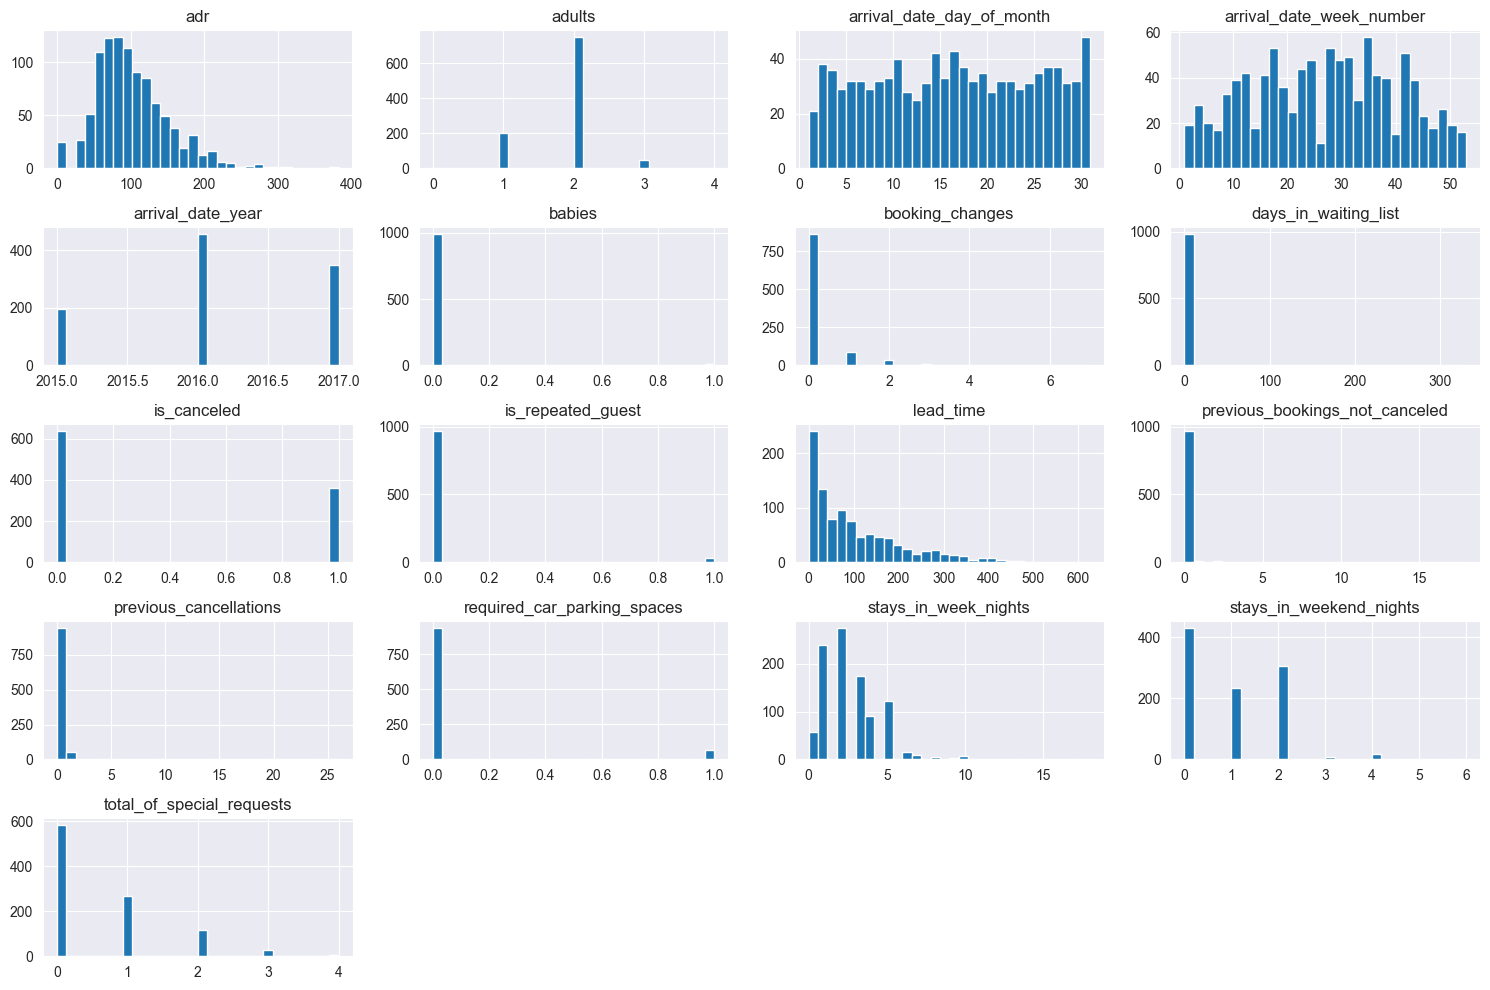

In [9]:
import matplotlib.pyplot as plt
df.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

And a look at whether any features are correlated with our target label.  Since the label is binary, Pearson's correlation will not work all that well, but it may still give us some early indications on whether there are useful features in the dataset.

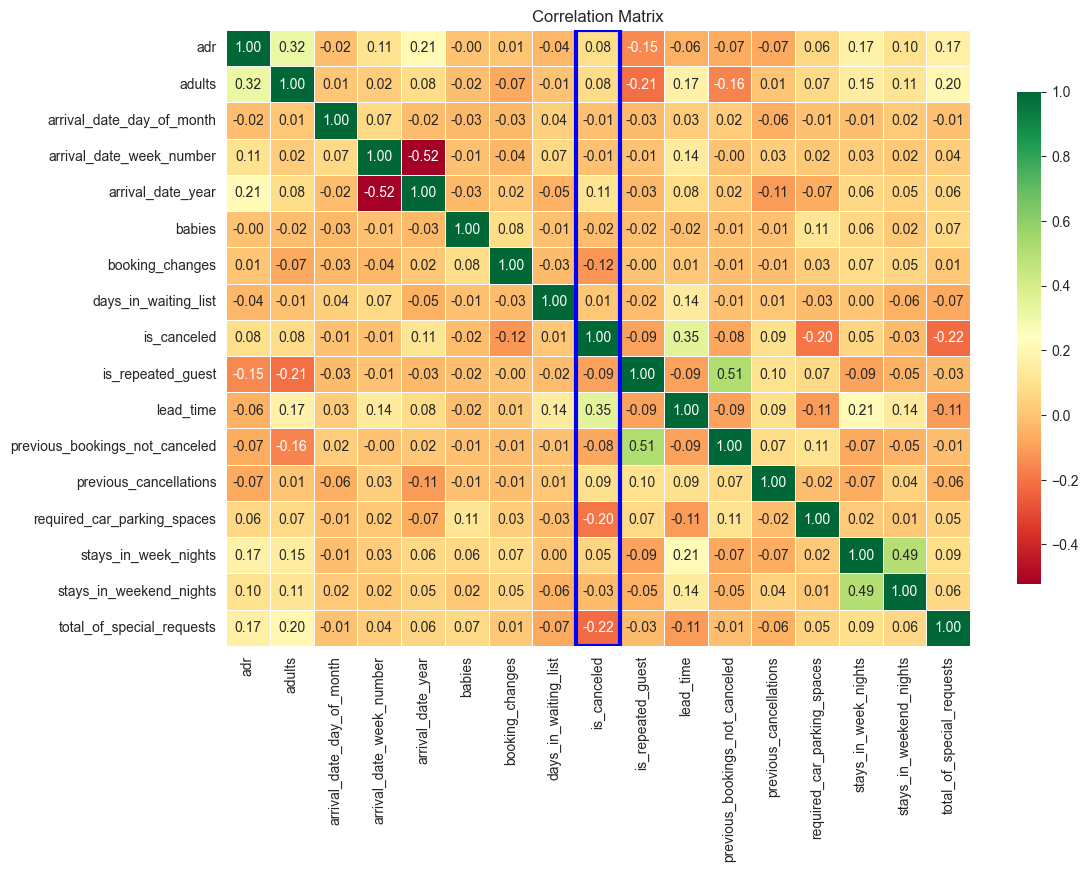

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numerical columns
numerical_df = df.select_dtypes(include=['int64', 'float64'])

# Calculate the correlation matrix
correlation_matrix = numerical_df.corr()

# Draw the heatmap with the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="RdYlGn", linewidths=.5, cbar_kws={"shrink": .8})

# Highlight the target label column
for i in range(len(correlation_matrix.columns)):
    if correlation_matrix.columns[i] == label:
        plt.gca().add_patch(plt.Rectangle((i, 0), 1, len(correlation_matrix.columns), fill=False, edgecolor='blue', lw=3))

plt.title("Correlation Matrix")
plt.show()

This correlation matrix shows how much each feature is correlated with every other feature.

The target label column is highlighted, and we can see some interesting correlations appearing:  

A booking is more likely to be cancelled if the lead time (how far ahead the booking is made) is long, or if booking changes are made, and less likely to be cancelled if the booking requires parking space(s) or has special requests.  These make some intuitive sense.

We would maybe expect cancellations to be more likely with more expensive rooms.  A room's price is represented (broadly) with the "adr" column:

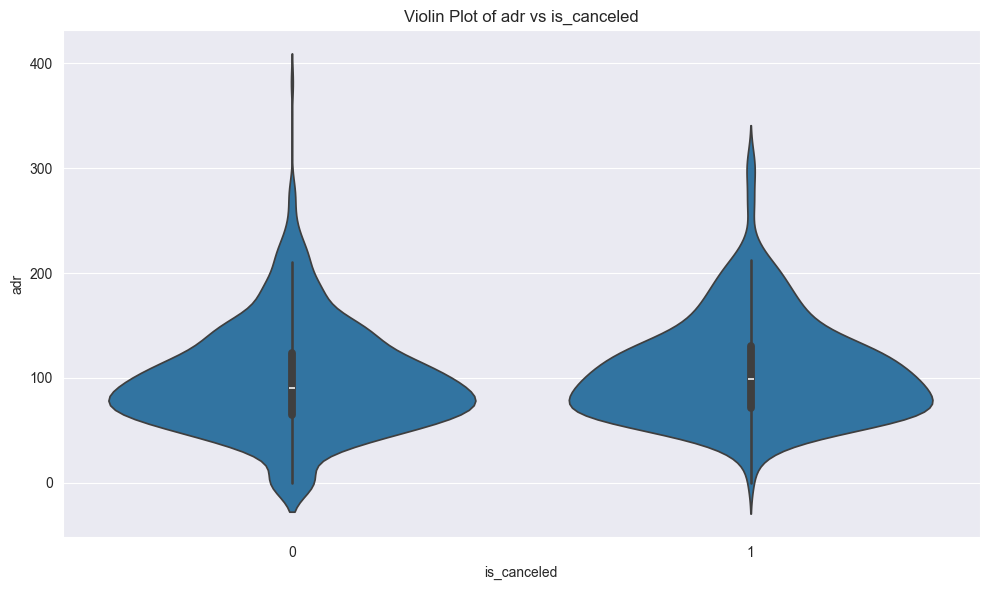

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='is_canceled', y='adr')
plt.title('Violin Plot of adr vs is_canceled')
plt.xlabel('is_canceled')
plt.ylabel('adr')
plt.tight_layout()
plt.show()

This violin plot suggests that indeed, cancellation is slightly more likely with higher room prices.

There are also several non-numerical features in the data.  ML models generally require numerical data, so we will need to decide what to do with these:

In [11]:
non_numerical_columns = [col for col, dtype in read_df.dtypes if dtype not in ('int', 'double', 'float', 'long', 'bigint')]
non_numerical_columns

['__META_ID',
 'agent',
 'arrival_date_month',
 'assigned_room_type',
 'children',
 'company',
 'country',
 'customer_type',
 'deposit_type',
 'distribution_channel',
 'hotel',
 'market_segment',
 'meal',
 'reservation_status',
 'reservation_status_date',
 'reserved_room_type']

A few of these look potentially useful, but many do not.  So for now, as we are doing initial data exploration and model-training, we will simply drop these columns during the data prep stage.  If the model performance turns out to be unsatisfactory, we can iterate and work out how to add some more of these features - for example, with one-hot encoding of the categorical data. 

# Model data prep
We've explored our data enough for now.  Let's proceed to prep it for Spark MLLib.

Here are the numerical columns that based on our initial data exploration we are going to proceed with.  We may need to iterate and add more features from the dataset later if the model performance is unsatisfactory, but this is a starting point:

In [12]:
input_columns = [
    "adr", "adults", "arrival_date_day_of_month", "arrival_date_week_number",
    "arrival_date_year", "babies", "booking_changes", "children",
    "days_in_waiting_list", "is_canceled", "is_repeated_guest", "lead_time",
    "previous_bookings_not_canceled", "previous_cancellations", "required_car_parking_spaces",
    "stays_in_week_nights", "stays_in_weekend_nights", "total_of_special_requests"
]
prep_df = read_df.select(input_columns)
prep_df.printSchema()

root
 |-- adr: double (nullable = true)
 |-- adults: long (nullable = true)
 |-- arrival_date_day_of_month: long (nullable = true)
 |-- arrival_date_week_number: long (nullable = true)
 |-- arrival_date_year: long (nullable = true)
 |-- babies: long (nullable = true)
 |-- booking_changes: long (nullable = true)
 |-- children: string (nullable = true)
 |-- days_in_waiting_list: long (nullable = true)
 |-- is_canceled: long (nullable = true)
 |-- is_repeated_guest: long (nullable = true)
 |-- lead_time: long (nullable = true)
 |-- previous_bookings_not_canceled: long (nullable = true)
 |-- previous_cancellations: long (nullable = true)
 |-- required_car_parking_spaces: long (nullable = true)
 |-- stays_in_week_nights: long (nullable = true)
 |-- stays_in_weekend_nights: long (nullable = true)
 |-- total_of_special_requests: long (nullable = true)



Most of these columns have been correctly interpreted from the original CSV file as numerical, except `children`:

In [16]:
df["children"].unique()

array(['0', '2', '1'], dtype=object)

There seems to be no good reason for that, so we'll simply convert the column into integer: 

In [17]:
prep_df = prep_df.withColumn("children", col("children").cast("int"))

Let's do a quick check for any null values, as models often do not handle these well:

In [18]:
from pyspark.sql.functions import col, sum
null_counts = prep_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in input_columns])
null_counts.show()

+---+------+-------------------------+------------------------+-----------------+------+---------------+--------+--------------------+-----------+-----------------+---------+------------------------------+----------------------+---------------------------+--------------------+-----------------------+-------------------------+
|adr|adults|arrival_date_day_of_month|arrival_date_week_number|arrival_date_year|babies|booking_changes|children|days_in_waiting_list|is_canceled|is_repeated_guest|lead_time|previous_bookings_not_canceled|previous_cancellations|required_car_parking_spaces|stays_in_week_nights|stays_in_weekend_nights|total_of_special_requests|
+---+------+-------------------------+------------------------+-----------------+------+---------------+--------+--------------------+-----------+-----------------+---------+------------------------------+----------------------+---------------------------+--------------------+-----------------------+-------------------------+
|  0|     0|    

No nulls to worry about in these columns.


Spark MLLib requires data be vectorized before being used in a model.  This simply combines all our chosen `input_column` features into a single `features` column.

In [19]:
from pyspark.ml.feature import VectorAssembler

input_columns_without_target_label = [col for col in input_columns if col != label]

# Assemble all columns except the label into a vector
features_col = "features"
vectorizer = VectorAssembler(inputCols=input_columns_without_target_label, outputCol=features_col)
encoded_df = vectorizer.transform(prep_df)
encoded_df

DataFrame[adr: double, adults: bigint, arrival_date_day_of_month: bigint, arrival_date_week_number: bigint, arrival_date_year: bigint, babies: bigint, booking_changes: bigint, children: int, days_in_waiting_list: bigint, is_canceled: bigint, is_repeated_guest: bigint, lead_time: bigint, previous_bookings_not_canceled: bigint, previous_cancellations: bigint, required_car_parking_spaces: bigint, stays_in_week_nights: bigint, stays_in_weekend_nights: bigint, total_of_special_requests: bigint, features: vector]

All we need now for the model training are the `features` and `label` columns:

In [20]:
final_df = encoded_df.select(features_col, label)
final_df

DataFrame[features: vector, is_canceled: bigint]

And finally, split the data into training and test sets.  We'll use the test set later to check that the model hasn't overfit the training data.

In [21]:
(training, test) = final_df.randomSplit([0.7, 0.3])

# Training a model with MLLib
With our data prepped, we're ready to train!

But first we need to select which model we will tain.  In a real-world project we could use MLLib's automated model selection capabilities, but for this simple example we will just try one or two.

We have a fairly small dataset (~100k rows) so we have to be very careful to avoid overfitting - so we'll avoid very sophisticated models like neural nets.  A gradient-boosted tree is often a good starting point, so we'll start there.  If we see too much overfitting, we can add regularization or consider changing to a simpler linear regression model.

Without further ado, let's train our model using MLLib's `GBTClassifier`:

In [22]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol=label, featuresCol=features_col, maxIter=10)
model = gbt.fit(training)

Done!  Let's see how it did.  

First we'll check how well it performs with the `training` dataset we just trained it on.  Let's create a function quickly to do this, so we can reuse it for the `test` set later.  We'll get it to display a confusion matrix, and the overall model accuracy:

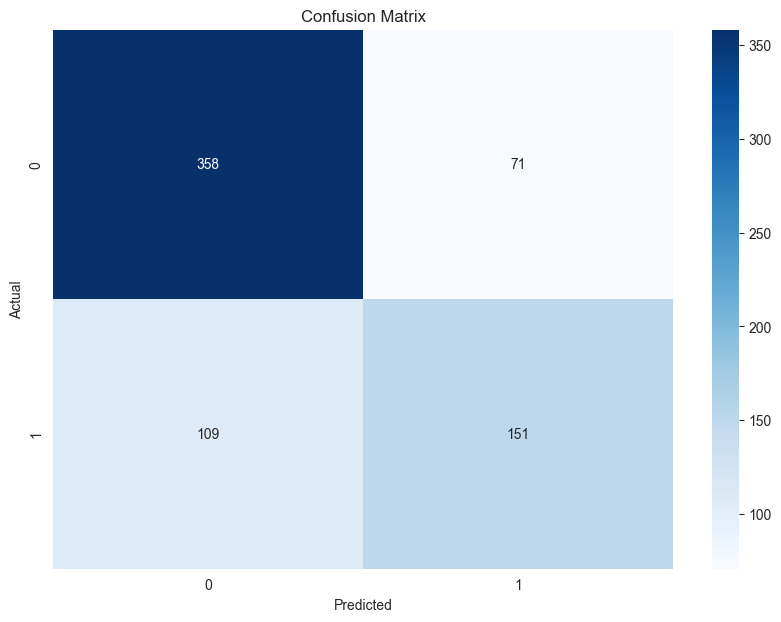

Accuracy on test data = 75.4717%


In [23]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix

def evaluate_model(model, dataset):
    predictions = model.transform(dataset)

    predictions_pd = predictions.select("prediction", label).toPandas()

    # Calculate the confusion matrix
    cm = confusion_matrix(predictions_pd[label], predictions_pd["prediction"])

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Calculate model accuracy
    evaluator = MulticlassClassificationEvaluator(labelCol=label, predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    print("Accuracy on test data = %g%%" % (accuracy * 100))

evaluate_model(model, training)

Looks pretty good!  

A confusion matrix is commonly used to assess how well the model performed.  It shows counts of actual `is_cancelled` values (left-axis) against what the model predicted (bottom-axis).  

The bottom right quadrant are the True Positives - where the model correctly predicted which bookings were cancelled.

And the top left quadrant are the True Negatives - where the model correctly predicted which bookings did not get cancelled.

But of course, the model made some mistakes, which are the other two quadrants.

Overall though, the model did very well, with a final accuracy score of over 70%.  Given the difficult context of trying to predict whether a booking will cancel, this seems very reasonable.

But of course, there is always the danger that the model has overfit its training data.  Earlier we reserved 30% of the dataset as the `test` data, which the model has not previously seen.  Let's see how it performs on that: 

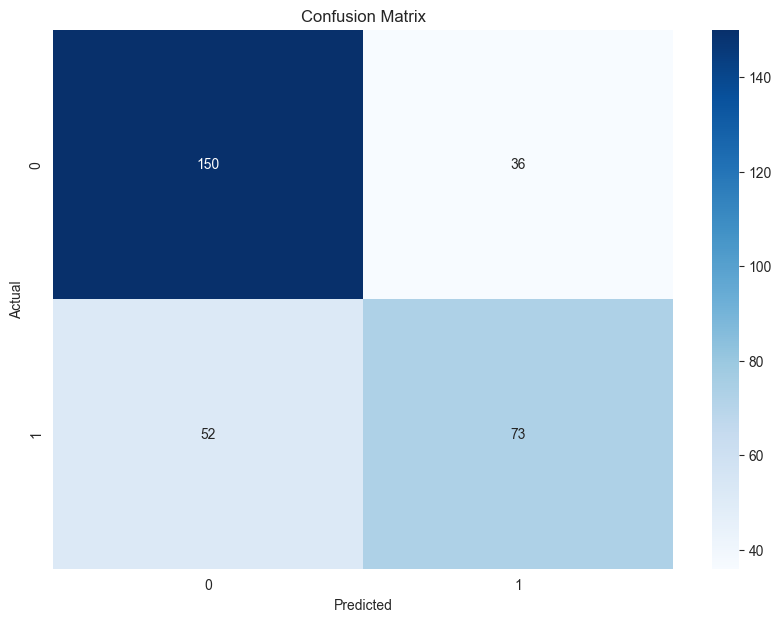

Accuracy on test data = 71.3826%


In [36]:
evaluate_model(model, test)

The results remain very good, so we can have some confidence that this model will have some predictive power as we provide it with future bookings.

Finally, let's look at what features the model found most useful:

In [50]:
# Extract the feature importances
importances = model.featureImportances

# Get the feature names from the VectorAssembler
feature_names = vectorizer.getInputCols()

feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances.toArray()
})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)

                           Feature  Importance
10                       lead_time    0.214342
0                              adr    0.121655
3         arrival_date_week_number    0.102803
16       total_of_special_requests    0.095334
13     required_car_parking_spaces    0.079439
2        arrival_date_day_of_month    0.079115
14            stays_in_week_nights    0.078820
1                           adults    0.065093
4                arrival_date_year    0.051645
12          previous_cancellations    0.034101
15         stays_in_weekend_nights    0.031698
6                  booking_changes    0.029477
11  previous_bookings_not_canceled    0.010681
5                           babies    0.002250
8             days_in_waiting_list    0.002216
7                         children    0.000989
9                is_repeated_guest    0.000342


`lead_time` was the most useful feature - and we saw during initial data exploration that this was quite highly correlated with `is_cancelled`.  

`adr` (roughly, the room's price) was the 2nd most important feature.

We can also see that we haven't accidentally included a feature that essentially duplicates the target label.

So the model looks good on this initial subset of 1000 rows.  If this were a real project, the next step would now be to go back and train it on the full dataset of 100k+ rows, and check the accuracy holds up - but this is a good point to end this example. 

# Further resources
Hopefully this whet your appetite for what is possible with Couchbase, Spark MLLib, and the Couchbase Spark Connector.

We invite you to checkout the other example notebooks and Python scripts in this repo, and to see the [documentation](https://docs.couchbase.com/spark-connector/current/pyspark.html).